<a href="https://colab.research.google.com/github/zubair761822/Image-Embeddings-/blob/main/Building_a_feautures_extraction_using_Python%2CSpark%2CCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a feautures extraction using Python,Spark,CNN :




## Introduction

In this notebook, I will use a CNN Model to create a Fashion Embedding. This information can be used in ML algorithms with higher semantic quality and similarity between Objects. We will use embeddings to identify similar items, this information will be used to recommend similar content in RecSys.

* **Introduction**
    * What is Embedding ?
    * How to use Embedding ?
* **Data Preparation**
* **Use Pre-Trained Model to Recommendation**
* Visualization Latent Space of Contents

#### Configure VM

In [ ]:
!pip install swifter
!pip install tensorflow==2.0.0

     |████████████████████████████████| 296 kB 4.3 MB/s 
     |████████████████████████████████| 132 kB 39.2 MB/s 


## What is Embedding ?

An embedding is a relatively low-dimensional space into which you can translate high-dimensional vectors. Embeddings make it easier to do machine learning on large inputs like sparse vectors representing words. Ideally, an embedding captures some of the semantics of the input by placing semantically similar inputs close together in the embedding space. An embedding can be learned and reused across models.

So a natural language modelling technique like Word Embedding is used to map words or phrases from a vocabulary to a corresponding vector of real numbers. As well as being amenable to processing by learning algorithms, this vector representation has two important and advantageous properties:

* **Dimensionality Reduction** — it is a more efficient representation
* **Contextual Similarity** — it is a more expressive representation

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSiR683wW4f9httU7krJeLcgDQRB3Fmxi4v2SIr8QLSht204cmk&s)

We can use the Embedding as input of the model, containing a reduced dimensionality but with much semantic information. 

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure
from pyspark.sql import SparkSession

In [5]:
import unittest

class LearnTest(unittest.TestCase):
	
  def test_func_1(self):
    pass
			
  def test_func_1(self):
    pass
		
if __name__ =="__main__":
	unittest.main()


E
ERROR: /root/ (unittest.loader._FailedTest)
----------------------------------------------------------------------
AttributeError: module '__main__' has no attribute '/root/'

----------------------------------------------------------------------
Ran 1 test in 0.003s

FAILED (errors=1)


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [17]:
!pip install sparkdl.estimators.keras_image_file_estimator

ERROR: Could not find a version that satisfies the requirement sparkdl.estimators.tensorflow.keras_image_file_estimator (from versions: none)
ERROR: No matching distribution found for sparkdl.estimators.tensorflow.keras_image_file_estimator


In [19]:
!pip install tensorframes

In [24]:
from tensorflow.keras.applications import inception_v3, xception, resnet50

In [32]:
pip install tensorflowonspark

     |████████████████████████████████| 45 kB 2.4 MB/s 


In [33]:
import os
import PIL.Image
import numpy as np
from pathlib import Path
from pyspark.sql import SparkSession
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from tensorflow.keras.applications import inception_v3, xception, resnet50
from sparkdl.estimators.keras_image_file_estimator import KerasImageFileEstimator

os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'


def load_data(folder):
    """
    Creates a list of dictionaries that contains all the labels and image routes

    :param folder: The train data path
    :return: A list of dictionaries with properties: 'uri' and 'one_hot_label'.
    """

    data = []

    image_class_folders = [sub_folder for sub_folder in folder.iterdir() if sub_folder.is_dir()]

    for class_folder in image_class_folders:
        images_folder = Path(str(class_folder) + '/images')

        images = [image_dir for image_dir in images_folder.iterdir()]

        for image in images:
            data.append({
                'one_hot_label': int(str(image).split('/').pop().split('_')[0][1:]),
                'uri': str(image)
            })

    return data


def load_train_data(base_path):
    """
    Gets the train data from the given base path

    :param base_path: Imagenet base path
    :return: A list of dictionaries with properties: 'uri' and 'one_hot_label'.
    """

    return load_data(Path(base_path + '/train'))


def load_image_from_uri(local_uri):
    """
    Returns a given image processed, for a given image route.

    :param local_uri: Full image route
    :return: Preprocessed tensor or Numpy array.
    """

    img = (PIL.Image.open(local_uri).convert('RGB').resize((299, 299), PIL.Image.ANTIALIAS))
    img_arr = np.array(img).astype(np.float32)
    img_tnsr = preprocess_input(img_arr[np.newaxis, :])
    return img_tnsr


if __name__ == '__main__':
    imagenet_path = 'tiny-imagenet-200'

    spark = SparkSession.builder \
        .master('local[2]') \
        .appName('ImageFeatureSelector') \
        .config('spark.executor.memory', '2G') \
        .config('spark.executor.cores', '2') \
        .config('spark.driver.memory', '3G') \
        .config('spark.driver.cores', '1') \
        .getOrCreate()

    train_df = spark.createDataFrame(load_train_data(imagenet_path))

    pre_trained_model = InceptionV3(weights="imagenet")
    pre_trained_model.save('/tmp/model-full.h5')

    estimator = KerasImageFileEstimator(inputCol="uri",
                                        outputCol="prediction",
                                        labelCol="one_hot_label",
                                        imageLoader=load_image_from_uri,
                                        kerasOptimizer='adam',
                                        kerasLoss='categorical_crossentropy',
                                        modelFile='/tmp/model-full-tmp.h5'  # local file path for model
                                        )

    param_grid = (ParamGridBuilder().addGrid(estimator.kerasFitParams, [{"batch_size": 32, "verbose": 0},
                                                                        {"batch_size": 64, "verbose": 0}]).build())

    binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label")
    cv = CrossValidator(estimator=estimator, estimatorParamMaps=param_grid, evaluator=binary_evaluator, numFolds=2)

    cv_model = cv.fit(train_df)

    print(cv_model)

FileNotFoundError: ignored

In [29]:
!pip install kafka-python

     |████████████████████████████████| 246 kB 4.3 MB/s 


In [2]:
pip install pyspark

     |████████████████████████████████| 281.3 MB 37 kB/s 
     |████████████████████████████████| 198 kB 33.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=5b7dea3a6184980767365620944e002692b8f254cc61d46024d7ee8241bcb026
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [4]:
spark = SparkSession.builder.master("local").appName("image_features_extractions").getOrCreate()

In [15]:
import spark.sql.functions._

ModuleNotFoundError: ignored

In [5]:
DATASET_PATH = "/content/drive/MyDrive/"
#print(os.listdir(DATASET_PATH))

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
a = spark.read.format("csv").option("header","true").load("/content/drive/MyDrive/styles.csv")
a.show(10)

+-----+------+--------------+-----------+-----------+----------+------+----+------+--------------------+
|   id|gender|masterCategory|subCategory|articleType|baseColour|season|year| usage|  productDisplayName|
+-----+------+--------------+-----------+-----------+----------+------+----+------+--------------------+
|15970|   Men|       Apparel|    Topwear|     Shirts| Navy Blue|  Fall|2011|Casual|Turtle Check Men ...|
|39386|   Men|       Apparel| Bottomwear|      Jeans|      Blue|Summer|2012|Casual|Peter England Men...|
|59263| Women|   Accessories|    Watches|    Watches|    Silver|Winter|2016|Casual|Titan Women Silve...|
|21379|   Men|       Apparel| Bottomwear|Track Pants|     Black|  Fall|2011|Casual|Manchester United...|
|53759|   Men|       Apparel|    Topwear|    Tshirts|      Grey|Summer|2012|Casual|Puma Men Grey T-s...|
| 1855|   Men|       Apparel|    Topwear|    Tshirts|      Grey|Summer|2011|Casual|Inkfruit Mens Cha...|
|30805|   Men|       Apparel|    Topwear|     Shirts|  

In [ ]:
!unrar x /content/drive/MyDrive/images_2.rar

Streaming output truncated to the last 5000 lines.
Extracting  images/58129.jpg                                              89%  OK 
Extracting  images/5813.jpg                                               89%  OK 
Extracting  images/58131.jpg                                              89%  OK 
Extracting  images/58132.jpg                                              89%  OK 
Extracting  images/58133.jpg                                              89%  OK 
Extracting  images/58135.jpg                                              89%  OK 
Extracting  images/58136.jpg                                              89%  OK 
Extracting  images/58137.jpg                                              89%  OK 
Extracting  images/58138.jpg                                              89%  OK 
Extracting  images/58139.jpg                                              89%  OK 
Extracting  images/5814.jpg  

In [9]:
df = pd.read_csv(DATASET_PATH +"styles.csv", nrows=5000, error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch,30039.jpg


In [22]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return "/content/images/"+img

def load_image(img, resized_fac = 0.1):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return img

In [11]:
from pyspark.sql.types import *

In [12]:
from pyspark.sql.functions import udf

In [13]:
convertUDF_img_path = udf(img_path)

In [14]:
convertUDF_get_embedding = udf(get_embedding)

NameError: ignored

In [15]:
convertUDF_load_image = udf(load_image)

In [16]:
convertUDF_plot_figures = udf(plot_figures)

In [37]:
!pip install validator

In [42]:
import unittest

In [43]:
import calc

ModuleNotFoundError: ignored

In [38]:
import validator

# Import the test framework (this is a hypothetical module)
import test_framework

# This is a generalized example, not specific to a test framework
#class Test_TestAccountValidator(test_framework.TestBaseClass):
   #def test_validator_valid_string():
        # The exact assertion call depends on the framework as well
        #assert(validate_account_number_format("1234567890"), true)


ModuleNotFoundError: ignored

In [16]:
import org.apache.spark.sql.expressions.UserDefinedFunction
import org.apache.spark.sql.functions.udf

ModuleNotFoundError: ignored

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

AttributeError: ignored

In [ ]:
!nvidia-smi


Wed Dec 15 07:43:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The Dataset is made up of different items that can be found in a marketplace. The idea is to use embeddings to search for similarity and find similar items just using the image.

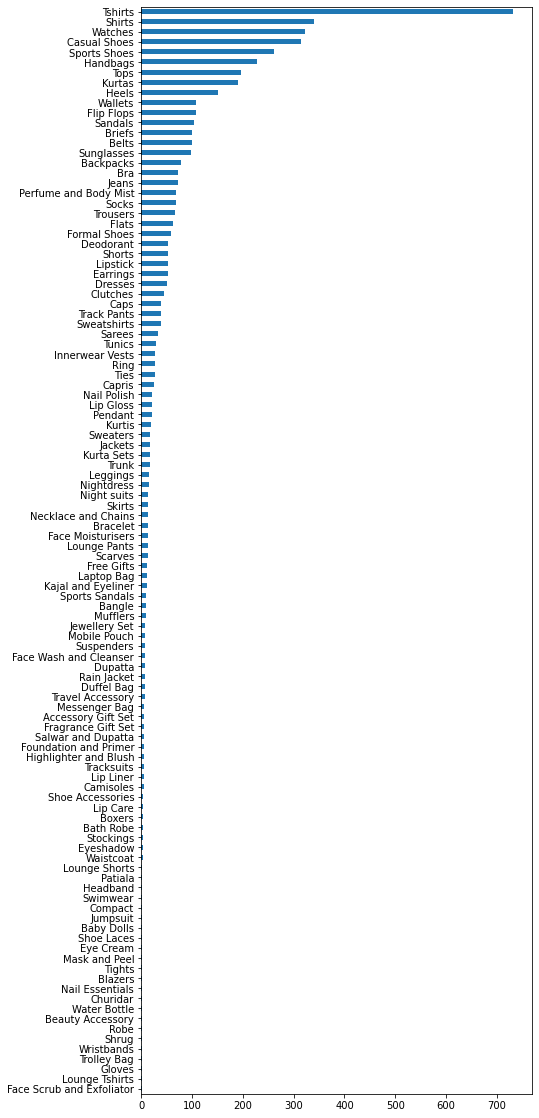

In [24]:
plt.figure(figsize=(7,20))
df.articleType.value_counts().sort_values().plot(kind='barh')

## Use Pre-Trained Model to Recommendation

In [25]:
import tensorflow as tf
import keras
from keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
tf.__version__

'2.7.0'

In [26]:
# Input Shape
img_width, img_height, _ = 224, 224, 3 #load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [27]:
def get_embedding(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

Get item Embedding

In [30]:
emb = get_embedding(model, df.iloc[0].image)
emb.shape

FileNotFoundError: ignored

In [31]:
img_array = load_image(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

AttributeError: ignored

In [ ]:
df.shape

(5000, 11)

Get Embedding for all itens in dataset

In [ ]:
%%time
#import swifter

# Parallel apply
df_sample      = df#.sample(10)
map_embeddings = df_sample['image'].apply(lambda img: get_embedding(model, img))
df_embs        = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()

(5000, 2048)
CPU times: user 7min, sys: 12.1 s, total: 7min 12s
Wall time: 7min 31s


#### Compute Similarity Between Items

![](http://dataaspirant.com/wp-content/uploads/2015/04/cosine.png)

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
from sklearn.metrics.pairwise import pairwise_distances




# Calcule DIstance Matriz
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

array([[0.99999994, 0.6358945 , 0.49575073, 0.59519005],
       [0.6358945 , 1.        , 0.509784  , 0.7375231 ],
       [0.49575073, 0.509784  , 1.        , 0.47131705],
       [0.59519005, 0.7375231 , 0.47131705, 0.9999994 ]], dtype=float32)

#### Recommender Similar Items

In [ ]:
indices = pd.Series(range(len(df)), index=df.index)
indices

# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

get_recommender(2993, df, top_n = 5)

(Int64Index([3349, 259, 3678, 2970, 1389], dtype='int64'),
 [0.90499943, 0.9024303, 0.8956701, 0.89079404, 0.88899004])

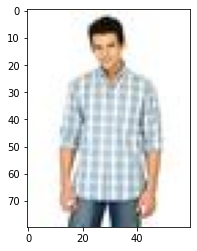

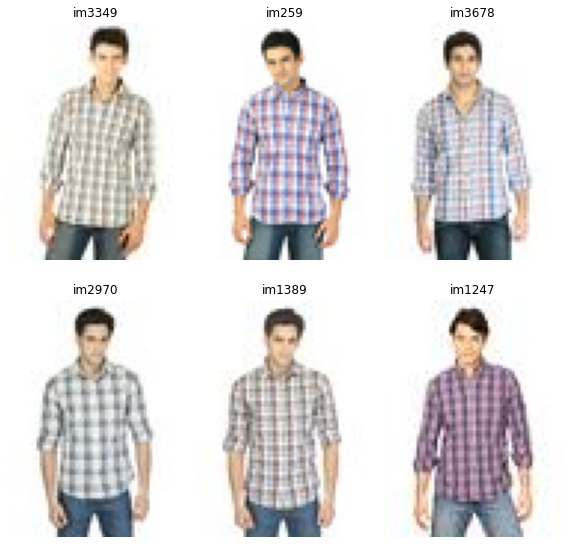

In [ ]:
# Idx Item to Recommender
idx_ref = 2993

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

**Search for items similar to the reference to recommend. Apparently it's working!**

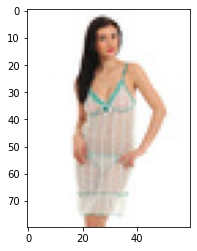

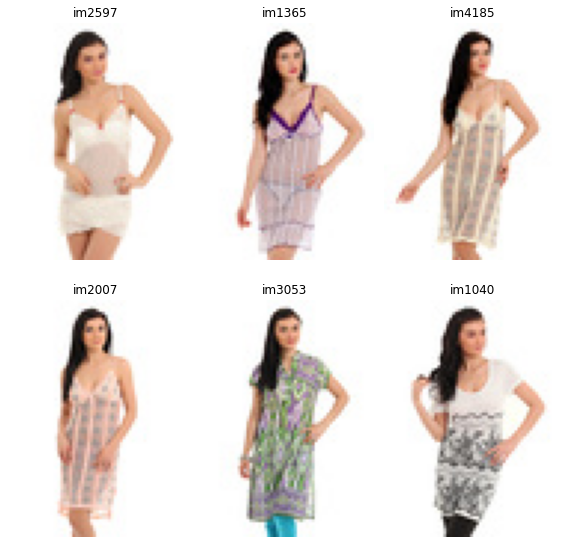

In [ ]:
idx_ref = 878

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

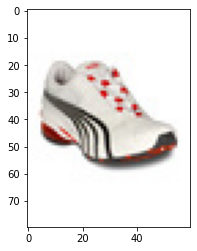

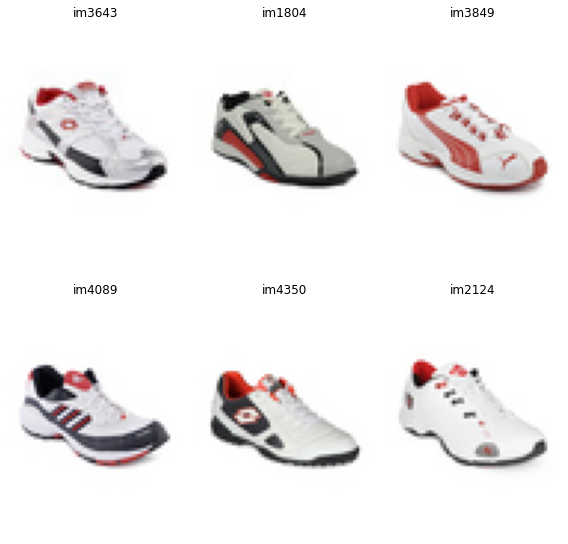

In [ ]:
idx_ref = 987

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

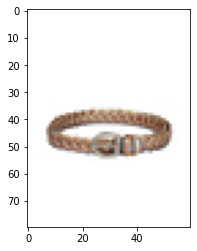

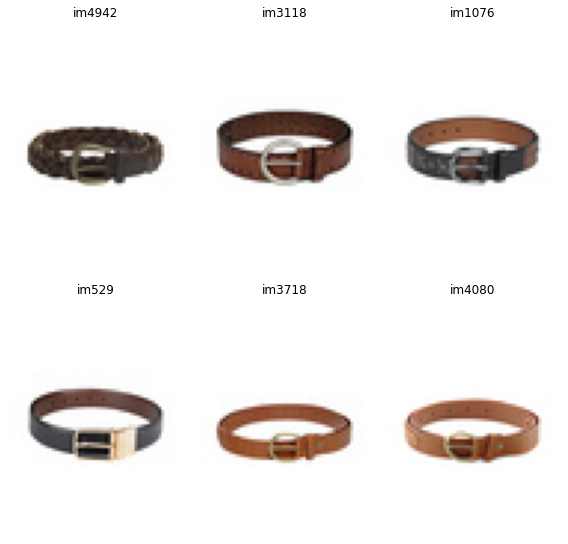

In [ ]:
idx_ref = 3524

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

## Visualization Latent Space of Contents

Since our latent space is not two-dimensional, we will use TSNE to reduce dimensionality, so we can use some interesting visualizations that can be made at this point. One is to look at the neighborhoods of different classes in the latent 2D plane:

In [ ]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [ ]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embs)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


t-SNE done! Time elapsed: 17.430025577545166 seconds


In [ ]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

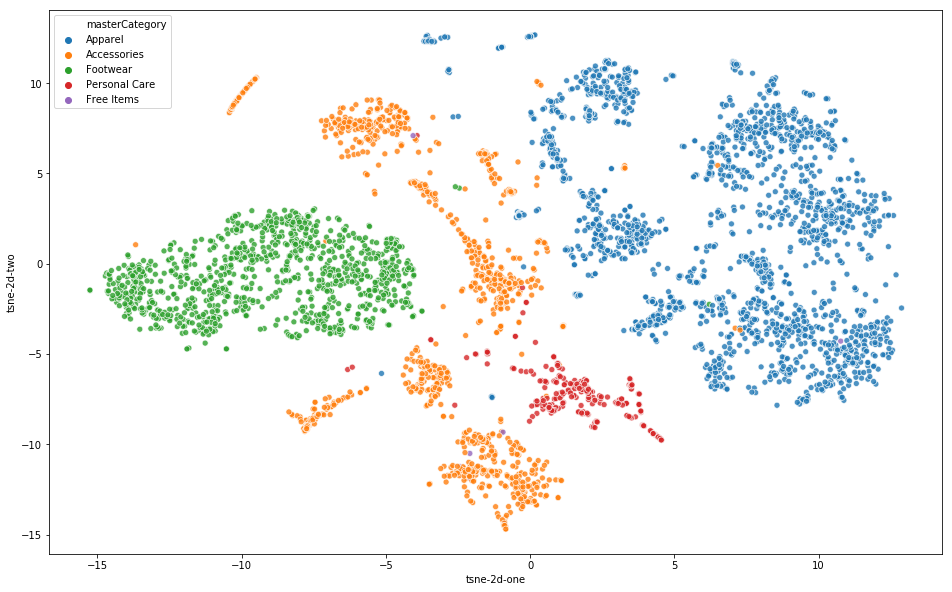

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

You can see different clusters generated by embeddings, which reinforces that features make sense. In this image above it is possible to observe the separation by Category, and in more detail by subcategory.

Of course there is actually a lot more information in embeddings, the visualization is for general understanding only

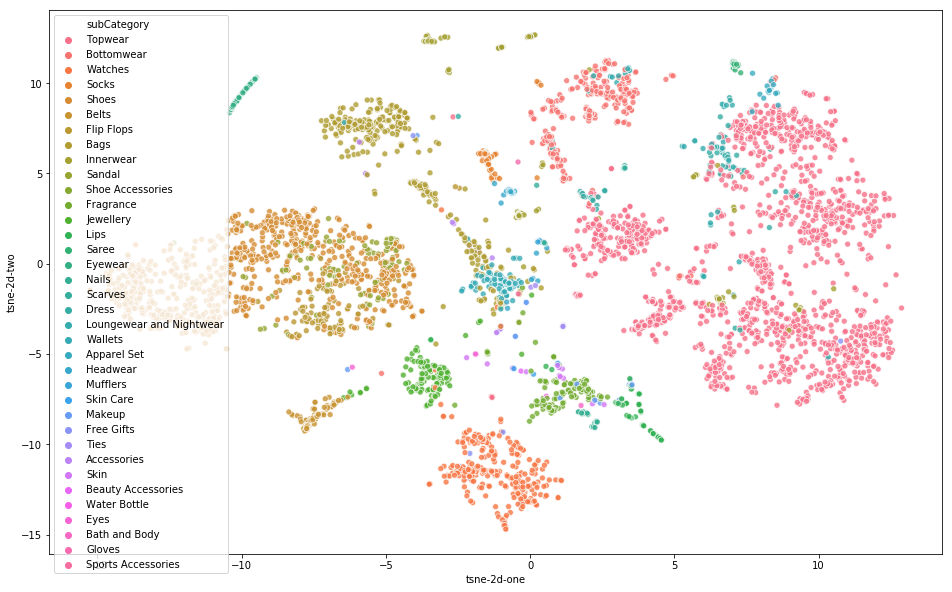

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

## Conclusion

Convolutional networks can be used to generate generic embeddings of any content. These embeddings can be used to identify similar items and in a recommendation process.

A big improvement would be to retrain some network layers in a dataset similar to the one that will be used. So the network learns better features for a specific problem.

In [ ]:
df.sample(10).to_csv('df_sample.csv')
df_embs.to_csv('embeddings.csv')
df.to_csv('metadados.csv')